In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from nltk.metrics import f_measure, precision, accuracy
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import QuestionAnsweringPipeline

sns.set_palette(palette='Paired')
sns.set_style('whitegrid')

In [2]:
from nltk.tokenize import word_tokenize

class QAEvaluate(object):
    """
    THis class is for the evaluation of Question Answering System
    """
    
    def __init__(self, model, tokenizer, top_k=1, return_answer_only=True, 
                 metric='F1', evaluate_tokenized=True):
        """
        This class implements a wrapper method for different evaluations on QuestionAnswering models from 
        Huggingface.com
        
        arguments:
        ------------------
        model:              QuestionAnswering model of HuggingFace
        tokenizer:          Tokenizer to QA model
        top_K:              Amount of answers to be returned of model.
                            Default = 1
        return_answer_only: Boolean to indicate if only the answer should be returned.
                            If not True the model will return a dict with probability and Span
        metric:             Metric to chose for the evaluation 
                            Default = "F1"
        evaluate_tokenized: If the evaluation should be made for tokenized answers or not.
                            Default = True
        """
        self.model = model
        self.tokenizer = tokenizer
        self.pipeline = QuestionAnsweringPipeline(model=model, 
                                                  tokenizer=tokenizer, 
                                                  top_k=top_k)
        self.return_answer_only = return_answer_only
        self.metric = metric
        self.evaluate_tokenized = evaluate_tokenized
        
    def answer_all(self, texts: np.ndarray, questions: np.ndarray):
        """
        Answers all questions given with corresponding texts.
        
        arguments:
        -------------
        texts:        an array of texts with dim = 0
        questions:    An array of questions of dim = 1
                      Each row in this matrix should correspond with the ID of the text in the given 
                      input array:
                      [[q1, q2, q3], [q1, q2,q3]]
        returns:
        -------------
        answers:      A dictionary of answers
        
        """
        answers = {}
        # Answer all Questions
        with tqdm(total=len(texts)*len(questions[0]), desc='Answering Questions') as pbar:
            for i, text in enumerate(texts):
                answers[i] = {}
                for j, question in enumerate(questions[i]):
                    answer = self.answer_question(question=question, text=text)
                    answers[i][j] = answer
                    pbar.update(1)
        
        return answers
    
    def evaluate(self, texts: np.ndarray, questions: np.ndarray, reference_answers: np.ndarray):
        """
        Methods calls functions to evaluate a given model with text, question and reference inputs.
        
        arguments:
        -------------
        texts:                an array of texts with dim = 0
                              Example: [text1, text2]
        questions:            An array of questions of dim = 1
                              Each row in this matrix should correspond with the ID of the text in the given 
                              input array:
                              Example: [[q1, q2, q3], [q1, q2,q3]]
        reference_answers:    An array of correct answers to given questions. Same shapes and dimensions like
                              questions.
        
        returns:
        -------------
        scores:               An array of scores in shape reference_answers.shape
        """
        # Call function to answer all by system
        answers = self.answer_all(texts=texts, questions=questions) 
        
        # Evaluate all questions    
        # Prepare answers as array
        answers = self._convert_to_array(answers)
        scores = self._calculate_scores(reference=reference_answers, test=answers)
        
        return scores
    
    def answer_question(self, question: str, text: str):
        """
        Methods calls functions to evaluate a given model with text, question and reference inputs.
        
        arguments:
        -------------
        question:     A question given as string
        text:         A text given as string
                
        returns:
        -------------
        answers:      Dictionary consisting of given question and answer
        """
        # Return answer from model
        answer = self.pipeline(question=question, context=text)
        
        if self.return_answer_only:
            answer = answer['answer']
        
        return dict(question=question, answer=answer)

            
    @staticmethod
    def _convert_to_array(A):
        """
        Converts given dictionary to an Array
        """
        answers = []
        for i, text in A.items():
            question_answers = []
            for j, qa in text.items():
                question_answers.append(qa['answer'])
            answers.append(question_answers)
            
        return np.array(answers, dtype=str)
    
    def _calculate_scores(self, reference, test):
        """
        Used for the calculation of the scores for each question given the reference.
        """
        if self.metric == 'F1':
            metric_func = f_measure
        elif self.metric == 'precision':
            metric_func = precision
        else:
            raise Exception('Metric does not fitted supported Functions within this class: [F1, accuracy, precision]')
            
        scores = self.__calculate_metric(metric_func=metric_func, reference=reference, 
                                         test=test, tokenized=self.evaluate_tokenized)
        
        return scores
        
    @staticmethod
    def __calculate_metric(metric_func, reference, test, tokenized=True):
        """
        Calculates Scores
        """
        assert reference.shape == test.shape 
        
        scores = np.empty(shape=reference.shape)
        for i in tqdm(range(reference.shape[0]), desc='Calculating Scores'):
            for j in range(reference.shape[1]):
                if tokenized:
                    # Tokenize Words
                    t, ref = set(word_tokenize(str(test[i, j]))), set(word_tokenize(str(reference[i, j])))
                else:
                    t, ref = set([test[i, j]]), set([reference[i, j]])
                # Score
                score = metric_func(reference=ref, test=t)
                scores[i, j] = score
                
        return scores

In [3]:
# Albert
albert_tokenizer = AutoTokenizer.from_pretrained("Firat/albert-base-v2-finetuned-squad")
albert = AutoModelForQuestionAnswering.from_pretrained("Firat/albert-base-v2-finetuned-squad")
albert_pipeline = QuestionAnsweringPipeline(model=albert, tokenizer=albert_tokenizer)

In [4]:
# Distilbert
distilbert_tokenizer = AutoTokenizer.from_pretrained("Firat/distilbert-base-uncased-finetuned-squad")
distilbert = AutoModelForQuestionAnswering.from_pretrained("Firat/distilbert-base-uncased-finetuned-squad")
distilbert_pipeline = QuestionAnsweringPipeline(model=distilbert, tokenizer=distilbert_tokenizer)

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

In [5]:
# Roberta
roberta_tokenizer = AutoTokenizer.from_pretrained("Firat/roberta-base-finetuned-squad")
roberta = AutoModelForQuestionAnswering.from_pretrained("Firat/roberta-base-finetuned-squad")
roberta_pipeline = QuestionAnsweringPipeline(model=roberta, tokenizer=roberta_tokenizer)

In [7]:
# Load Questions
data = pd.read_excel('./questions_collection.xlsx')
data.columns = [col.lower() for col in data.columns]
data.head(2)

,id,topic,difficulty (1-3),text,question 1,answer 1,question 2,answer 2,question 3,answer 3
0,1,history,1,"World War II or the Second World War, often ab...",When took the second World War place?,1939 to 1945,How many personnel was involved?,more than 100 million,Who were the majority of fatalities?,civilians
1,2,health,3,Occupational therapy (OT) is a profession with...,Occupational therapy is profession within whic...,healthcare,By who is it performed?,occupational therapists and occupational thera...,What are common occupational therapy inerventi...,"helping children with disabilities, injury reh..."


In [8]:
texts = data.loc[:, 'text'].to_list()
questions = data.loc[:, ['question 1', 'question 2', 'question 3']].to_numpy()
reference_answers = data.loc[:, ['answer 1', 'answer 2', 'answer 3']].to_numpy()
print(questions.shape)

(15, 3)


In [9]:
evaluator = QAEvaluate(model=albert, tokenizer=albert_tokenizer, top_k=1, 
                       return_answer_only=True, metric='F1', evaluate_tokenized=True)
albert_scores = evaluator.evaluate(texts=texts, questions=questions, 
                            reference_answers=reference_answers)

Answering Questions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
evaluator = QAEvaluate(model=distilbert, tokenizer=distilbert_tokenizer, top_k=1, 
                       return_answer_only=True, metric='F1', evaluate_tokenized=True)
distilbert_scores = evaluator.evaluate(texts=texts, questions=questions, 
                            reference_answers=reference_answers)

Answering Questions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
evaluator = QAEvaluate(model=roberta, tokenizer=roberta_tokenizer, top_k=1, 
                       return_answer_only=True, metric='F1', evaluate_tokenized=True)
roberta_scores = evaluator.evaluate(texts=texts, questions=questions, 
                            reference_answers=reference_answers)

Answering Questions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
f1_scores = [albert_scores.T,distilbert_scores.T,roberta_scores.T]

In [13]:
# Load Questions
data = pd.read_excel('./questions_collection.xlsx')
data.columns = [col.lower() for col in data.columns]
data.head(2)

,id,topic,difficulty (1-3),text,question 1,answer 1,question 2,answer 2,question 3,answer 3
0,1,history,1,"World War II or the Second World War, often ab...",When took the second World War place?,1939 to 1945,How many personnel was involved?,more than 100 million,Who were the majority of fatalities?,civilians
1,2,health,3,Occupational therapy (OT) is a profession with...,Occupational therapy is profession within whic...,healthcare,By who is it performed?,occupational therapists and occupational thera...,What are common occupational therapy inerventi...,"helping children with disabilities, injury reh..."


In [14]:
data = data.astype(str)

In [15]:
#data.iloc[8][9] = "50%"

In [16]:
data

,id,topic,difficulty (1-3),text,question 1,answer 1,question 2,answer 2,question 3,answer 3
0,1,history,1,"World War II or the Second World War, often ab...",When took the second World War place?,1939 to 1945,How many personnel was involved?,more than 100 million,Who were the majority of fatalities?,civilians
1,2,health,3,Occupational therapy (OT) is a profession with...,Occupational therapy is profession within whic...,healthcare,By who is it performed?,occupational therapists and occupational thera...,What are common occupational therapy inerventi...,"helping children with disabilities, injury reh..."
2,3,tech,2,"In deep learning, each level learns to transfo...",What can a raw input may be?,a matrix of pixels,What does the second layer?,compose and encode arrangements,What network is it about?,None
3,4,offtopic,1,"The series focuses on Monkey D. Luffy, a young...",On who focuses the series?,Monkey D. Ruffy,What is the name of the pirate crew?,Straw Hat Pirates,How is the mythical treasure called?,One Piece
4,5,news,2,He told a news conference Mr Putin would pay a...,What would Putin pay for invading?,serious and dear price,Who warned that the comments could further des...,The Kremlin,How many troops are near of the border?,100
5,6,tech,2,Bitcoin is a decentralized digital currency th...,What is Bitcoin?,decentralized digital currency,Who is the creator of bitcoin?,Satoshi Nakamoto,Why Bitcoins aren't backed by the government?,Because there’s nothing to guarantee their value.
6,7,history,1,"Inhabited since at least 1800 BC, Varanasi is ...",What is Varanasi well known as?,for being among the oldest living cities on Earth,How many hindus live in Varanasi?,1.2 billion,How many stone ghat steps does the city have?,88
7,8,bibliography,1,"After Will Smith met Jeff Townes at age 16, th...",How long starred Will Smith on the sitcom The ...,six seasons,Where was Will Smith born?,in Philadelphia,For what Will Smith earned acclaim?,Concussion
8,9,product description,1,The Apple MacBook Air is a laptop computer wit...,How much does the computer weigh?,3 pounds,Why does the computer have no moving parts?,It has a fanless design,How much percent can i charge in 30 minutes?,0.5
9,10,tech,3,With worldwide unique measuring systems the Sw...,In what is WSL pioneer?,research of bedload transport in flowing waters,Since when are measurement signals recorded?,2018,What are the names of the three measuring syst...,"Miniplate Accelorometer (MPA), Square Pipe Sys..."


In [17]:
pipelines = [albert_pipeline,distilbert_pipeline,roberta_pipeline]
models = ["Albert","Distilbert","Roberta"]

In [18]:
pred_data = data.iloc[:,1:4]

In [19]:
for k in range(3):
    question = "question " + str(k+1)
    answer = "answer " + str(k+1)
    for j in range(len(pipelines)):
        pred_answer = []
        prob_answer = []
        for i in range(len(data)):
            answer_tokens = pipelines[j](question=data.loc[i, question], context=data.loc[i, 'text'])
            pred_answer.append(answer_tokens["answer"])
            prob_answer.append(answer_tokens["score"])
        pred_data[question] = data[question]
        pred_data[answer] = data[answer]
        pred_data[models[j]+" pred "+str(k+1)] = pred_answer
        pred_data[models[j]+" prob_"+str(k+1)] = np.round(prob_answer,3)
        pred_data[models[j]+" F1_"+str(k+1)] = np.round(f1_scores[j][k],3)

In [20]:
pd.options.display.width = 100
pd.options.display.max_columns = 100
pred_data

,topic,difficulty (1-3),text,question 1,answer 1,Albert pred 1,Albert prob_1,Albert F1_1,Distilbert pred 1,Distilbert prob_1,Distilbert F1_1,Roberta pred 1,Roberta prob_1,Roberta F1_1,question 2,answer 2,Albert pred 2,Albert prob_2,Albert F1_2,Distilbert pred 2,Distilbert prob_2,Distilbert F1_2,Roberta pred 2,Roberta prob_2,Roberta F1_2,question 3,answer 3,Albert pred 3,Albert prob_3,Albert F1_3,Distilbert pred 3,Distilbert prob_3,Distilbert F1_3,Roberta pred 3,Roberta prob_3,Roberta F1_3
0,history,1,"World War II or the Second World War, often ab...",When took the second World War place?,1939 to 1945,1939 to 1945.,0.682,0.857,1939 to 1945,0.767,1.000,1945,0.441,0.500,How many personnel was involved?,more than 100 million,more than 100 million,0.448,1.000,100 million,0.451,0.667,more than 100 million,0.451,1.000,Who were the majority of fatalities?,civilians,civilians.,0.874,0.667,civilians,0.785,1.000,civilians,0.953,1.000
1,health,3,Occupational therapy (OT) is a profession with...,Occupational therapy is profession within whic...,healthcare,healthcare.,0.983,0.667,healthcare,0.980,1.000,healthcare,0.992,1.000,By who is it performed?,occupational therapists and occupational thera...,occupational therapists and occupational thera...,0.570,0.714,occupational therapists and occupational thera...,0.665,1.000,occupational therapists and occupational thera...,0.574,0.714,What are common occupational therapy inerventi...,"helping children with disabilities, injury reh...",helping children with disabilities to particip...,0.046,0.462,"injury rehabilitation, and providing supports ...",0.074,0.692,helping children with disabilities to particip...,0.079,0.400
2,tech,2,"In deep learning, each level learns to transfo...",What can a raw input may be?,a matrix of pixels,a matrix of pixels;,0.869,0.889,a matrix of pixels,0.453,1.000,a matrix of pixels,0.946,1.000,What does the second layer?,compose and encode arrangements,may compose and encode arrangements of edges;,0.757,0.667,compose and encode arrangements of edges,0.702,0.800,compose and encode arrangements of edges,0.764,0.800,What network is it about?,None,"deep learning,",0.012,0.000,deep learning,0.121,0.000,deep learning,0.058,0.000
3,offtopic,1,"The series focuses on Monkey D. Luffy, a young...",On who focuses the series?,Monkey D. Ruffy,"Monkey D. Luffy,",0.983,0.571,Monkey D. Luffy,0.660,0.667,Monkey D. Luffy,0.978,0.667,What is the name of the pirate crew?,Straw Hat Pirates,the Straw Hat Pirates.,0.481,0.750,Straw Hat Pirates,0.694,1.000,Straw Hat Pirates,0.671,1.000,How is the mythical treasure called?,One Piece,"the One Piece,",0.741,0.667,the One Piece,0.746,0.800,One Piece,0.527,1.000
4,news,2,He told a news conference Mr Putin would pay a...,What would Putin pay for invading?,serious and dear price,"""serious and dear price""",0.483,0.800,"a ""serious and dear price",0.601,0.800,"a ""serious and dear price",0.318,0.800,Who warned that the comments could further des...,The Kremlin,The Kremlin,0.840,1.000,The Kremlin,0.790,1.000,The Kremlin,0.926,1.000,How many troops are near of the border?,100,100,0.756,1.000,100,0.624,1.000,100,0.442,1.000
5,tech,2,Bitcoin is a decentralized digital currency th...,What is Bitcoin?,decentralized digital currency,a decentralized digital currency,0.496,0.857,a decentralized digital currency,0.503,0.857,a decentralized digital currency that you can ...,0.188,0.375,Who is the creator of bitcoin?,Satoshi Nakamoto,"Satoshi Nakamoto,",0.994,0.800,Satoshi Nakamoto,0.995,1.000,Satoshi Nakamoto,0.996,1.000,Why Bitcoins aren't backed by the government?,Because there’s nothing to guarantee their value.,"their decentralized nature,",0.346,0.143,Core to their decentralized nature,0.020,0.267,there’s nothing to guarantee their value,0.182,0.889
6,history,1,"Inhabited since at least 1800 BC, Varanasi is ...",What is Varanasi well known as?,for being among the oldest living cities on Earth,"among the oldest living cities on Earth,",0.573,0.824,oldest liv

In [21]:
pred_data.to_csv('df_pred_prob_f1.csv',index=True)

In [22]:
albert_prob = pred_data.iloc[:,6:][pred_data.iloc[:,6:].columns[::11]]
albert_F1 = pred_data.iloc[:,7:][pred_data.iloc[:,7:].columns[::11]]

In [23]:
distilbert_prob = pred_data.iloc[:,9:][pred_data.iloc[:,9:].columns[::11]]
distilbert_F1 =pred_data.iloc[:,10:][pred_data.iloc[:,10:].columns[::11]]

In [24]:
roberta_prob = pred_data.iloc[:,12:][pred_data.iloc[:,12:].columns[::11]]
roberta_F1 = pred_data.iloc[:,13:][pred_data.iloc[:,13:].columns[::11]]

In [25]:
albert_prob_sum = sum(np.sum(albert_prob))/35
albert_F1_sum = sum(np.sum(albert_F1))/35
distilbert_prob_sum = sum(np.sum(distilbert_prob))/35
distilbert_F1_sum = sum(np.sum(distilbert_F1))/35
roberta_prob_sum = sum(np.sum(roberta_prob))/35
roberta_F1_sum = sum(np.sum(roberta_F1))/35

In [26]:
prob_sum = [albert_prob_sum,distilbert_prob_sum,roberta_prob_sum]
F1_sum = [albert_F1_sum,distilbert_F1_sum,roberta_F1_sum]

In [67]:
list_albert_prob = list(albert_prob.iloc[:,0])+list(albert_prob.iloc[:,1])+list(albert_prob.iloc[:,2])
list_albert_f1 = list(albert_F1.iloc[:,0])+list(albert_F1.iloc[:,1])+list(albert_F1.iloc[:,2])

In [68]:
list_distilbert_prob = list(distilbert_prob.iloc[:,0])+list(distilbert_prob.iloc[:,1])+list(distilbert_prob.iloc[:,2])
list_distilbert_f1 = list(distilbert_F1.iloc[:,0])+list(distilbert_F1.iloc[:,1])+list(distilbert_F1.iloc[:,2])

In [74]:
list_roberta_prob = list(roberta_prob.iloc[:,0])+list(roberta_prob.iloc[:,1])+list(roberta_prob.iloc[:,2])
list_roberta_f1 = list(roberta_F1.iloc[:,0])+list(roberta_F1.iloc[:,1])+list(roberta_F1.iloc[:,2])

In [ ]:
list(zip(prob_sum,F1_sum))

[(0.7330857142857142, 0.7516857142857142),
 (0.6686285714285715, 0.7780285714285714),
 (0.7398285714285714, 0.85)]

In [75]:
list_albert_prob_df = pd.DataFrame(list_albert_prob,columns=["prob"])
list_albert_prob_df["f1"] = list_albert_f1
list_albert_prob_df["model"] = "albert"

In [76]:
list_distilbert_prob_df = pd.DataFrame(list_distilbert_prob,columns=["prob"])
list_distilbert_prob_df["f1"] = list_distilbert_f1
list_distilbert_prob_df["model"] = "distilbert"

In [77]:
list_roberta_prob_df = pd.DataFrame(list_roberta_prob,columns=["prob"])
list_roberta_prob_df["f1"] = list_roberta_f1
list_roberta_prob_df["model"] = "roberta"

In [30]:
models

['Albert', 'Distilbert', 'Roberta']

In [79]:
df = pd.concat([list_albert_prob_df, list_distilbert_prob_df, list_roberta_prob_df], axis=0)

In [33]:
cmap = sns.color_palette('Greys', 10)
c1, c2 = cmap[2], cmap[6]

In [82]:
df.columns

Index(['prob', 'f1', 'model'], dtype='object')

C:\Users\Firat\anaconda3\envs\deel\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


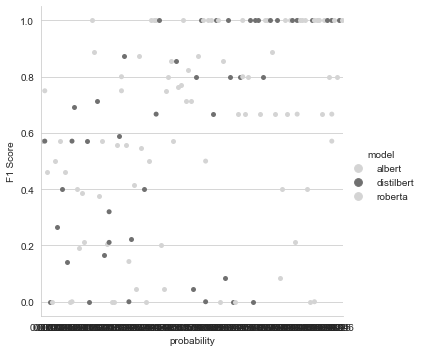

In [84]:
sns.catplot(x= "prob", y='f1',hue="model", data=df, kind='swarm', palette=[c1, c2])
plt.xlabel("probability")
plt.ylabel("F1 Score")
plt.show()

In [89]:
from numpy.polynomial.polynomial import polyfit

In [91]:
x = df["prob"]
y = df["f1"]

In [92]:
b, m = polyfit(x, y, 1)

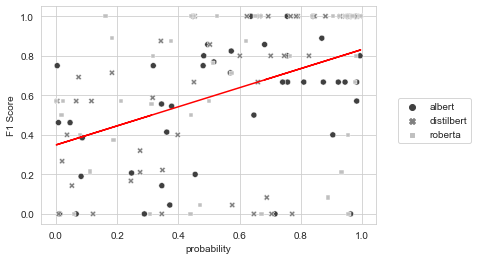

In [104]:
sns.scatterplot(x= "prob", y='f1',hue="model", data=df, palette="gray",style='model')
plt.plot(x, b + m * x, '-',c="r")
plt.xlabel("probability")
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.show()

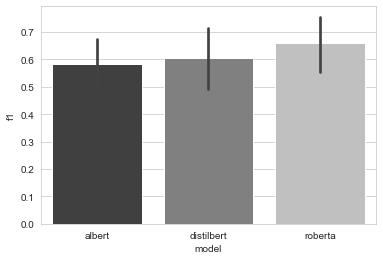

In [116]:
sns.barplot(x= "model", y='f1', data=df, palette="gray")

plt.show()